##### Imports #####

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Plots
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score # Split
from sklearn.linear_model import LogisticRegression #Baseline model (Logistic regression)
from sklearn import metrics #Asses model
import copy #For deepcopy
import seaborn as sns # confusion matrix
import sklearn
from sklearn.metrics import confusion_matrix # confusion matrix
from sklearn.metrics import roc_curve
from sklearn.preprocessing import MinMaxScaler # Scaler
from sklearn.neural_network import MLPClassifier # Nural network

In [20]:
# Import dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

##### Data overview and preperation #####

In [21]:
# Overview
print(train.head())
print()
print(train.info())

      ID  age         job  marital  education default  balance housing loan  \
0  13829   29  technician   single   tertiary      no    18254      no   no   
1  22677   26    services   single  secondary      no      512     yes  yes   
2  10541   30  management   single  secondary      no      135      no   no   
3  13689   41  technician  married    unknown      no       30     yes   no   
4  11304   27      admin.   single  secondary      no      321      no  yes   

    contact  day month  campaign  pdays  previous poutcome   y  
0  cellular   11   may         2     -1         0  unknown  no  
1   unknown    5   jun         3     -1         0  unknown  no  
2  cellular   14   aug         2     -1         0  unknown  no  
3  cellular   10   jul         1     -1         0  unknown  no  
4   unknown    2   sep         1     -1         0  unknown  no  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12870 entries, 0 to 12869
Data columns (total 17 columns):
 #   Column     Non-Null 

We see that there is no missing values in the dataset.

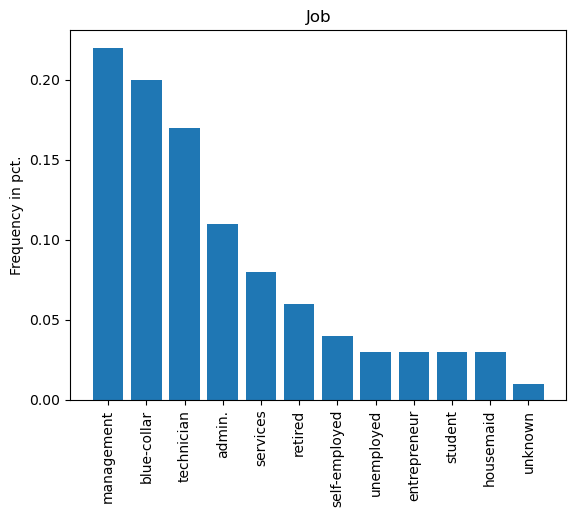

{'management': 2858, 'blue-collar': 2571, 'technician': 2141, 'admin.': 1464, 'services': 1043, 'retired': 770, 'self-employed': 454, 'unemployed': 414, 'entrepreneur': 383, 'student': 358, 'housemaid': 334, 'unknown': 80}


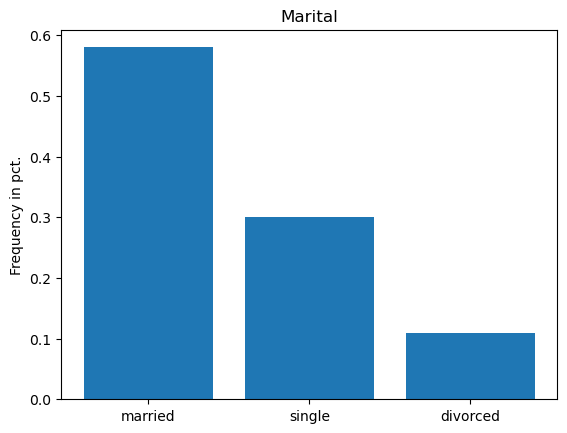

{'married': 7490, 'single': 3905, 'divorced': 1475}


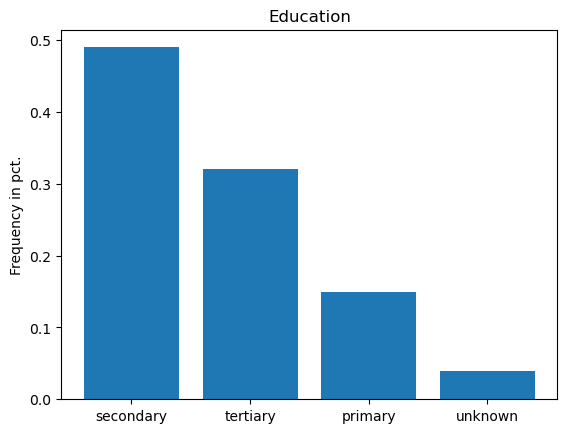

{'secondary': 6368, 'tertiary': 4075, 'primary': 1880, 'unknown': 547}


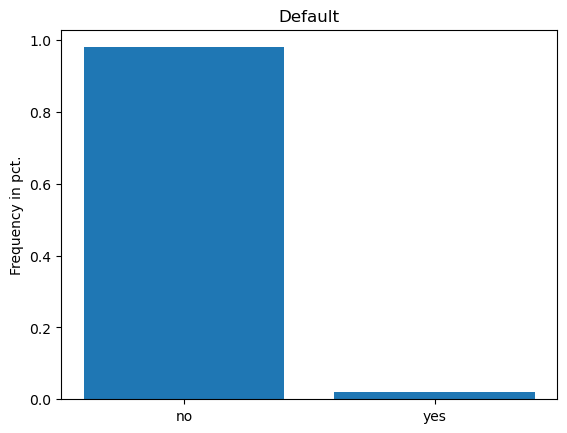

{'no': 12662, 'yes': 208}


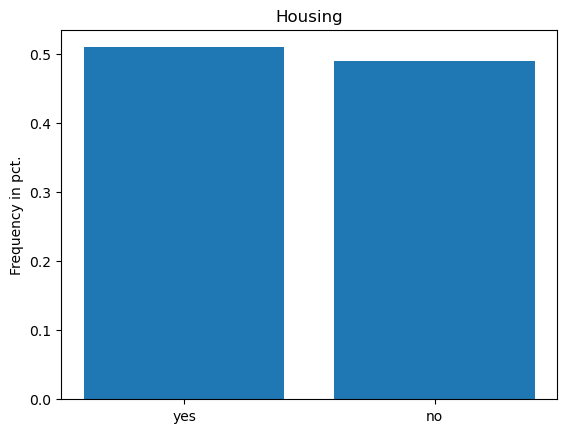

{'yes': 6605, 'no': 6265}


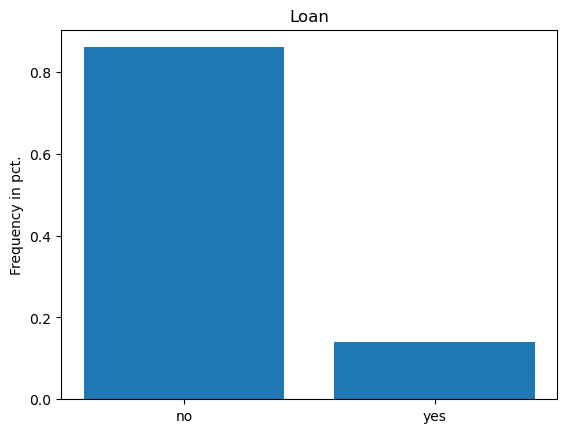

{'no': 11060, 'yes': 1810}


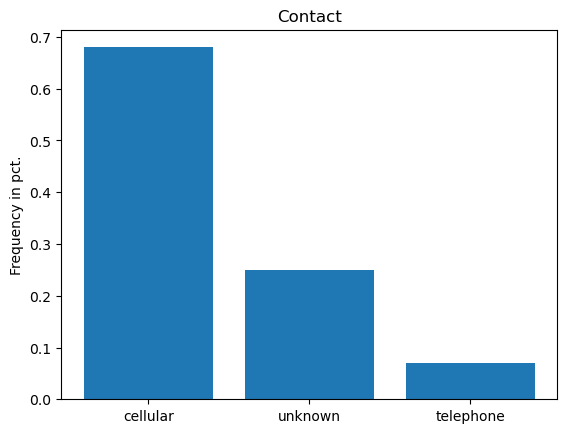

{'cellular': 8756, 'unknown': 3239, 'telephone': 875}


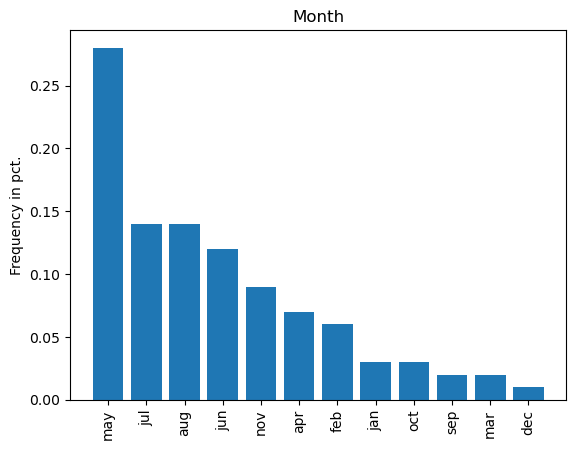

{'may': 3594, 'jul': 1823, 'aug': 1811, 'jun': 1484, 'nov': 1094, 'apr': 908, 'feb': 831, 'jan': 375, 'oct': 338, 'sep': 274, 'mar': 237, 'dec': 101}


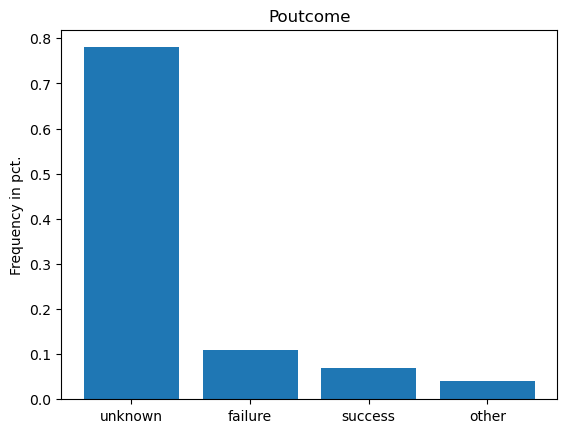

{'unknown': 10070, 'failure': 1380, 'success': 845, 'other': 575}


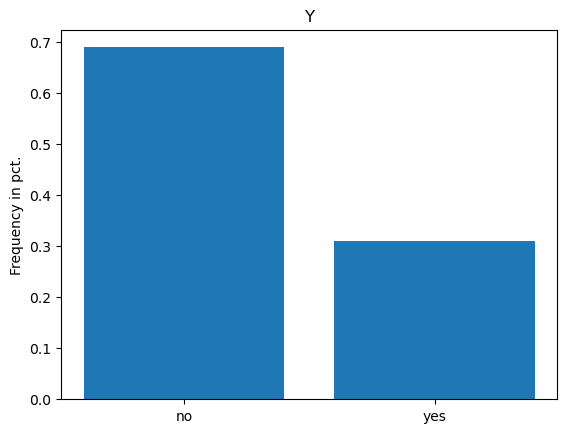

{'no': 8903, 'yes': 3967}


In [22]:
''' Helper function:
    Takes a list and returns the distribution in percent '''
def listPercentage(inp):
    total = sum(inp)
    lst = []
    for elm in inp:
        value = elm / total
        value = round(value, 2)
        lst.append(value)
    return lst

''' Creates a barplot of a dictionary'''
def dictplot(inp, title):
    names = list(inp.keys())
    values = list(inp.values())
    values = listPercentage(values)

    fig, ax = plt.subplots()
    ax.set_ylabel('Frequency in pct.')
    if len(names) > 4:
        plt.xticks(rotation = 90)
    ax.set_title(title.capitalize())
    
    plt.bar(range(len(data)), values, tick_label=names)
    plt.show()

for col in train.select_dtypes(object):
    target = train[col]
    data = dict(target.value_counts())
    dictplot(data, str(col))
    print(data)

In [23]:
train['yBinary'] = np.nan
train.loc[train['y'] == 'no', 'yBinary'] = 0
train.loc[train['y'] == 'yes', 'yBinary'] = 1
train.drop(['y'], axis = 1, inplace = True)
print('Mean Target is ', train['yBinary'].mean())

Mean Target is  0.30823620823620823


In [24]:
x_train, x_test, y_train, y_test = train_test_split(train, train['yBinary'], test_size = 0.2, random_state = 1)

##### Baseline (Logistic regression) #####

In [25]:
# Data preproccesing
x1_train = copy.deepcopy(x_train)
x1_test = copy.deepcopy(x_test)

x1_train = pd.get_dummies(x1_train)
x1_test = pd.get_dummies(x1_test)

x1_train.drop(['yBinary'], axis = 1, inplace= True)
x1_test.drop(['yBinary'], axis = 1, inplace= True)
x1_train.drop(['ID'], axis = 1, inplace= True)
x1_test.drop(['ID'], axis = 1, inplace= True)

In [26]:
# Model
modelC = LogisticRegression(C=0.1, class_weight=None, solver='liblinear', max_iter=1000)
modelC.fit(x1_train, y_train) 
y1_predC = modelC.predict(x1_test) 

In [27]:
# Model evaluation
print("Logistic MSE:",metrics.mean_squared_error(y_test, y1_predC))
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, y1_predC))
print("\nLogistic Regression Precision:",metrics.precision_score(y_test, y1_predC))
print("Logistic Regression Recall:",metrics.recall_score(y_test, y1_predC))

Logistic MSE: 0.22921522921522922
Logistic Regression Accuracy: 0.7707847707847708

Logistic Regression Precision: 0.7002341920374707
Logistic Regression Recall: 0.392904073587385


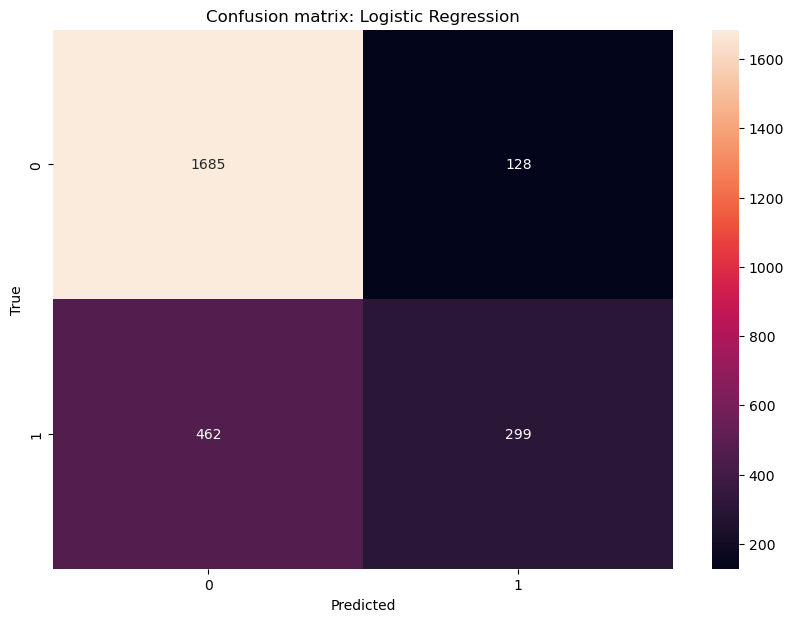

In [28]:
# Confusion matrix
cm = confusion_matrix(y_test, y1_predC)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix: Logistic Regression')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

We see that the amount of false negatives is larger than the amount of true negeatives. The goal for the advanced model is to reverse this relationship. i.e get a higher recall.

##### Advanced model #####

In [29]:
x2_train = copy.deepcopy(x_train)
x2_test = copy.deepcopy(x_test)
print(x2_test.head())

          ID  age            job   marital  education default  balance  \
7180   13092   32  self-employed    single   tertiary      no      444   
12579  22522   66        retired   married   tertiary      no     1948   
10474  19318   35         admin.    single  secondary      no      111   
8830   11376   32    blue-collar   married  secondary      no      180   
1555   18331   50     technician  divorced   tertiary      no      291   

      housing loan   contact  day month  campaign  pdays  previous poutcome  \
7180       no   no  cellular   19   nov         1     -1         0  unknown   
12579      no   no  cellular   28   jan         1     91         4  success   
10474     yes   no  cellular   29   jan         1    195         3  failure   
8830      yes   no  cellular   14   apr         1    334         1    other   
1555       no  yes  cellular   17   jul         1     -1         0  unknown   

       yBinary  
7180       0.0  
12579      1.0  
10474      0.0  
8830       0

In [30]:
#Dimensionality reduction
dropCol = ['yBinary', 'ID', 'balance']
for elm in dropCol:
    x2_train.drop([elm], axis = 1, inplace= True)
    x2_test.drop([elm], axis = 1, inplace= True)

In [31]:
#Convert categorical variable into dummy/indicator variables.
x2_train = pd.get_dummies(x2_train)
x2_test = pd.get_dummies(x2_test)

In [32]:
#Scale selected data between 0 and 1
scalerData = ['age', 'campaign', 'pdays']
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x2_train[scalerData])
x2_train[scalerData] = scaler.transform(x2_train[scalerData])
x2_test[scalerData] = scaler.transform(x2_test[scalerData])

In [39]:
print(x2_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2574 entries, 7180 to 12702
Data columns (total 49 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  2574 non-null   float64
 1   day                  2574 non-null   int64  
 2   campaign             2574 non-null   float64
 3   pdays                2574 non-null   float64
 4   previous             2574 non-null   int64  
 5   job_admin.           2574 non-null   uint8  
 6   job_blue-collar      2574 non-null   uint8  
 7   job_entrepreneur     2574 non-null   uint8  
 8   job_housemaid        2574 non-null   uint8  
 9   job_management       2574 non-null   uint8  
 10  job_retired          2574 non-null   uint8  
 11  job_self-employed    2574 non-null   uint8  
 12  job_services         2574 non-null   uint8  
 13  job_student          2574 non-null   uint8  
 14  job_technician       2574 non-null   uint8  
 15  job_unemployed       2574 non-null

In [33]:
#Nural network model using stochastic gradient descent.
modelC = MLPClassifier(random_state=1, max_iter=300, activation='logistic', solver='adam', learning_rate='adaptive')
modelC.fit(x2_train, y_train) 
y2_predC = modelC.predict(x2_test) 


c:\Users\alx26\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Logistic MSE: 0.20745920745920746
Logistic Regression Accuracy: 0.7925407925407926
Logistic Regression Precision: 0.705244122965642
Logistic Regression Recall: 0.5124835742444153
f1_score :  0.5936073059360731


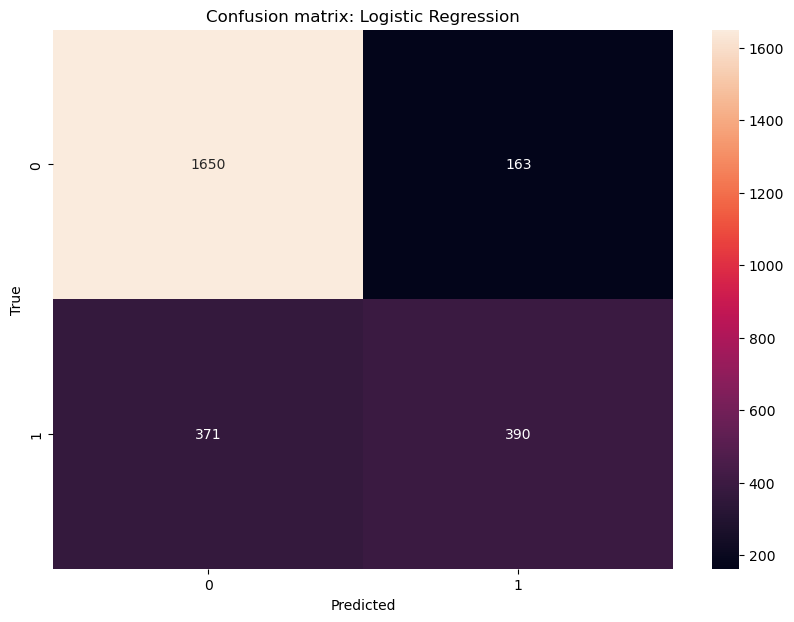

[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0,

In [34]:
print("Logistic MSE:",metrics.mean_squared_error(y_test, y2_predC))
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, y2_predC))
print("Logistic Regression Precision:",metrics.precision_score(y_test, y2_predC))
print("Logistic Regression Recall:",metrics.recall_score(y_test, y2_predC))
print("f1_score : ", metrics.f1_score(y_test, y2_predC))

cm = confusion_matrix(y_test, y2_predC)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix: Logistic Regression')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()
print(list(y_test))
print(list(y2_predC))

In [35]:
# Mean target
def average(inp):
    return sum(inp) / len(inp)
print('Mean y2_predC: ', average(y2_predC))
print('Mean difference from target: ', train['yBinary'].mean() - average(y2_predC))

Mean y2_predC:  0.21484071484071485
Mean difference from target:  0.09339549339549338


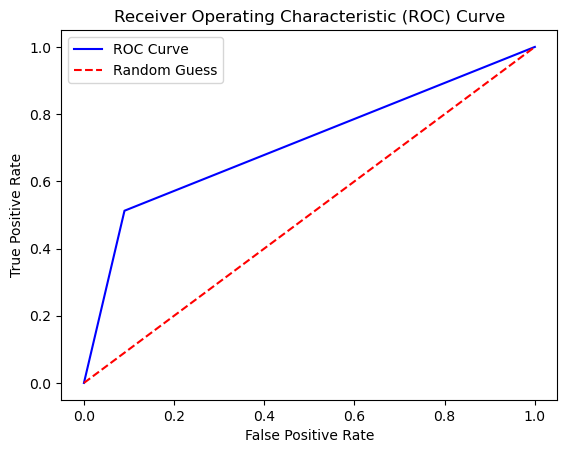

Area under curve:  0.7112886707405198


In [36]:
#Roc curve
def plotRocCurve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Plot the ROC curve
    plt.plot(fpr, tpr, color='blue', label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


plotRocCurve(y_test, y2_predC)
print('Area under curve: ', sklearn.metrics.roc_auc_score(y_test, y2_predC))


The model is good measured on accuracy alone, with an accuracy of ~0.79 <br>
The previous set target is met, by having more True Negatives than type I errors. <br>
The model is better than random guess, but with a recall on ~0.5 it still miss half of the True positives. <br> <br>
With this type of problem it's better to predict that a client won't subscribe a term deposite and be pleasently suprised. Meaning that it's better to have an overweight og type I errors rather than type II. 